# Model 1
## Dataset: ridership data Chicago

## Programmer: Giovanni Vecchione
## Date: 4/4/24

In [4]:
import tensorflow as tf
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)

In [3]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [8]:

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [9]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

All recurrent layers in Keras expect 3D inputs of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series.

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the Chicago's Data Portal.

In [10]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [11]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [12]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


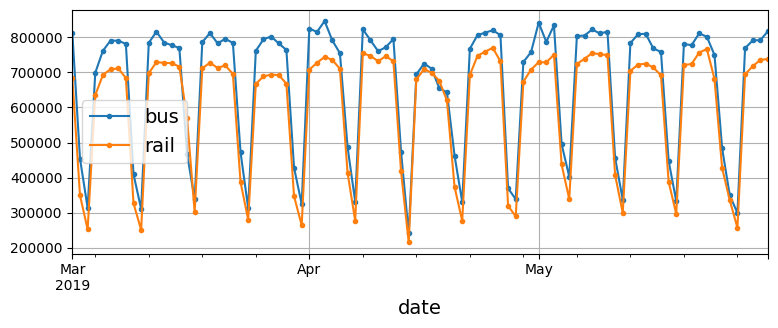

In [13]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code - saves the figure for the book
plt.show()

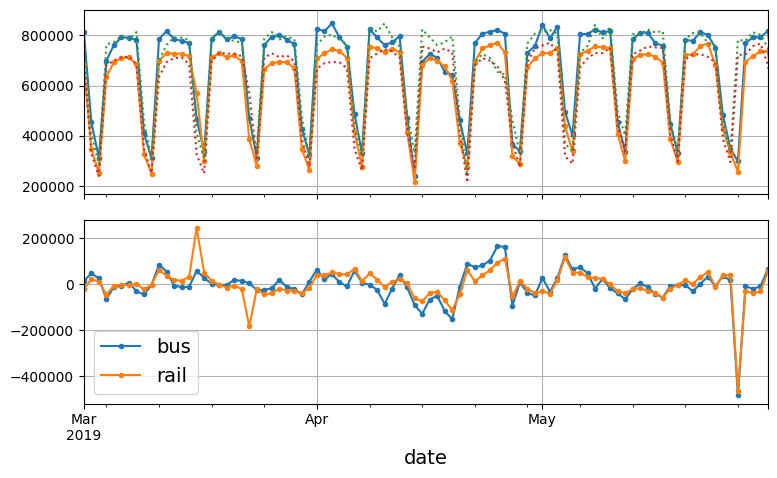

In [14]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code - beautifies the plot
save_fig("differencing_plot")  # extra code - saves the figure for the book
plt.show()

In [15]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [16]:
#NOTE - Mean absolute error (MAE), also called mean absolute deviation (MAD)
diff_7.abs().mean() 

bus     43915.608696
rail    42143.271739
dtype: float64

In [17]:
#NOTE - Mean absolute percentage error (MAPE):
targets = df[["bus", "rail"]]["2019-03":"2019-05"] 
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

C:\Users\GioDude\AppData\Local\Temp\ipykernel_20996\2308752717.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()  # compute the mean for each month


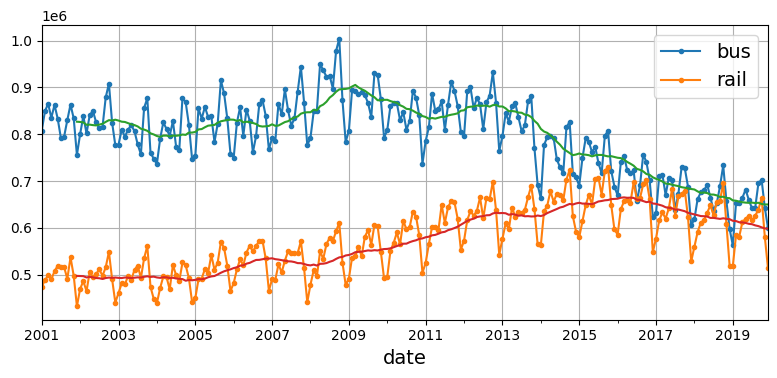

In [18]:
#NOTE - Now let's look at the yearly seasonality and the long-term trends:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code - saves the figure for the book
plt.show()

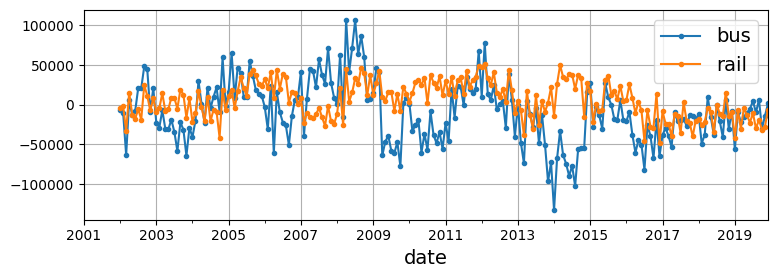

In [19]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code - saves the figure for the book
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [22]:
y_pred[0]  # ARIMA forecast

427758.62628589093

In [23]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [24]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [25]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [26]:
mae

32040.720089838298

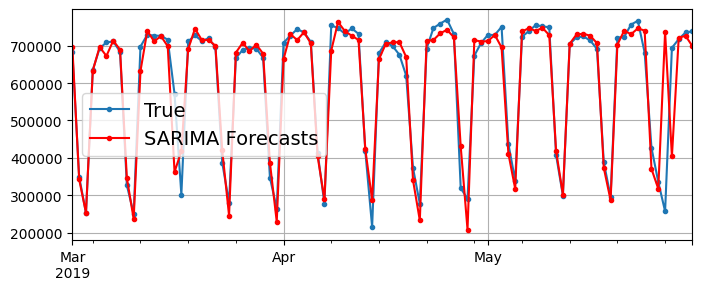

In [27]:
# extra code - displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

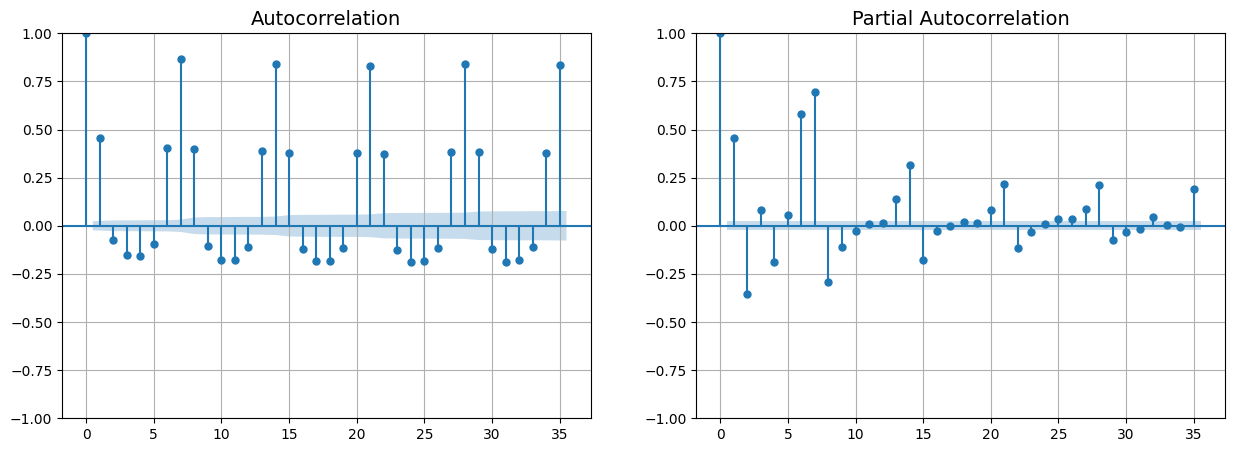

In [28]:
# extra code - shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [29]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [30]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [31]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [32]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [33]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [34]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [35]:
seq_length = 56
tf.random.set_seed(42)  # extra code - ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


c:\Users\GioDude\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2675 - mae: 0.6185 - val_loss: 0.0114 - val_mae: 0.1165
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - mae: 0.1326 - val_loss: 0.0099 - val_mae: 0.1091
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - mae: 0.1058 - val_loss: 0.0073 - val_mae: 0.0875
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mae: 0.0917 - val_loss: 0.0070 - val_mae: 0.0886
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - mae: 0.0946 - val_loss: 0.0065 - val_mae: 0.0801
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - mae: 0.0841 - val_loss: 0.0069 - val_mae: 0.0842
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060 - mae: 0.0819 - val_loss: 0.0056 - val_mae: 0.0757
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mae: 0.0774 - val_loss: 0.0054 - val_mae: 0.0710
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mae: 0.0

In [37]:
# extra code - evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0395 


38046.87038064003